## Import library

In [81]:
import random
import json
import numpy as np
import nltk
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
%matplotlib inline
stemmer = PorterStemmer()

#PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Tokenization

In [82]:
def tokenize(sentence):
    return nltk.word_tokenize(sentence)

## Stemming

In [83]:
def stem(word):
    return stemmer.stem(word.lower())


## Bag of words

In [84]:
def bag_of_words(tokenized_sentence, words):
    sentence_words = [stem(word) for word in tokenized_sentence]
    bag = np.zeros(len(words), dtype=np.float32)
    for idx, w in enumerate(words):
        if w in sentence_words: 
            bag[idx] = 1

    return bag

## load Data

In [85]:
with open('data/health_medicine.json', 'r') as f:
    intents = json.load(f)

## Data Preprocessing

In [86]:
all_words = []
tags = []
xy = []
sentences = []
true_tags = []

for intent in intents['intents']:
    tag = intent['tags']
    tags.append(tag)
    for pattern in intent['patterns']:
        sentences.append(pattern)
        true_tags.append(tag)
        w = tokenize(pattern)
        all_words.extend(w)
        xy.append((w, tag))

ignore_words = ['?', '.', '!']
all_words = [stem(w) for w in all_words if w not in ignore_words]
all_words = sorted(set(all_words))
tags = sorted(set(tags))

print(len(xy), "patterns")
print(len(tags), "tags:", tags)
print(len(sentences), "sentences:", sentences)
print(len(true_tags), "true_tags:", true_tags)
print(len(all_words), "unique stemmed words:", all_words)

18 patterns
6 tags: ['clinical', 'diet', 'health', 'medicine', 'mental health', 'physical examination']
18 sentences: ['What is health?', 'define health', 'Improve health', 'importance of medicine?', 'scenario of medicine', 'Improve medicine', 'Explain mental health?', 'Provide mental health', 'Improve mental health', ' How to do  clinical practice?', 'define clinical', 'Improve clinical', 'Improve diet?', 'which include in a diet', 'define diet', 'How to know about physical examination?', 'Explain physical examination', 'Provide physical examination']
18 true_tags: ['health', 'health', 'health', 'medicine', 'medicine', 'medicine', 'mental health', 'mental health', 'mental health', 'clinical', 'clinical', 'clinical', 'diet', 'diet', 'diet', 'physical examination', 'physical examination', 'physical examination']
26 unique stemmed words: ['a', 'about', 'clinic', 'defin', 'diet', 'do', 'examin', 'explain', 'health', 'how', 'import', 'improv', 'in', 'includ', 'is', 'know', 'medicin', 'ment

In [87]:
tag_samples = {}

for w, tag in xy:
    if tag in tags:
        if tag not in tag_samples.keys():
            tag_samples[tag] = 1
        else:
            tag_samples[tag] += 1
print (tag_samples)

{'health': 3, 'medicine': 3, 'mental health': 3, 'clinical': 3, 'diet': 3, 'physical examination': 3}


In [88]:
import pandas as pd
sample_f = pd.DataFrame.from_dict(tag_samples, orient='index', columns=['no_samples'])
sample_f.head()

,no_samples
health,3
medicine,3
mental health,3
clinical,3
diet,3


## Neural Network Model

In [89]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Linear(hidden_size, hidden_size) 
        self.l3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

## Creating X_train, Y_train

In [90]:
X_train = []
y_train = []
for (pattern_sentence, tag) in xy:
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)
    label = tags.index(tag)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

## Hyper-parameters 

In [100]:
num_epochs = 1000
batch_size = 10
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size = 8
output_size = len(tags)
print(input_size, output_size)

26 6


## Chat Dataset

In [101]:
class ChatDataset(Dataset):

    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.n_samples

## Data Loader and Device config 

In [102]:
dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

model = NeuralNet(input_size, hidden_size, output_size).to(device)

## Loss and optimizer

In [103]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train the model

In [104]:
running_loss=0
correct=0
total=0
eval_losses=[]
eval_accu=[]
costs = []
for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)
        
        # Forward pass
        outputs = model(words)
        loss = criterion(outputs, labels)

        # Backward 
        optimizer.zero_grad()
        loss.backward()
        #update weight
        optimizer.step()
        running_loss += loss.item()
     
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        train_loss=running_loss/len(train_loader)
        accu=100.*correct/total
    eval_losses.append(train_loss)
    eval_accu.append(accu)

  
    if (epoch+1) % 100 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        costs.append(loss)

print(f'final loss: {loss.item():.4f}')
print(f'training complete.')

Epoch [100/1000], Loss: 1.4423
Epoch [200/1000], Loss: 0.4329
Epoch [300/1000], Loss: 0.1105
Epoch [400/1000], Loss: 0.0228
Epoch [500/1000], Loss: 0.0211
Epoch [600/1000], Loss: 0.0095
Epoch [700/1000], Loss: 0.0047
Epoch [800/1000], Loss: 0.0054
Epoch [900/1000], Loss: 0.0035
Epoch [1000/1000], Loss: 0.0022
final loss: 0.0022
training complete.


# Plot the Losses(cost) vs Iteration(per hundred)

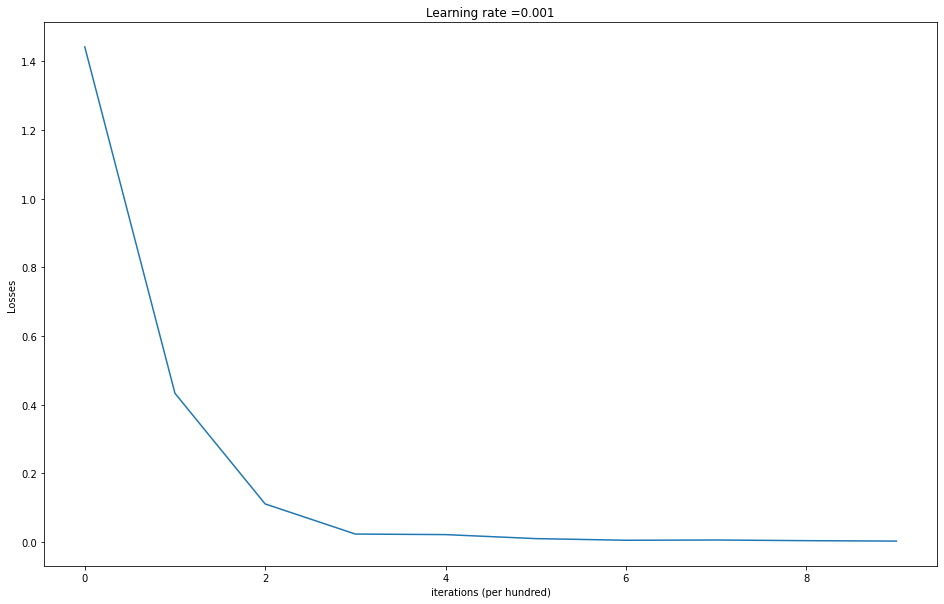

In [129]:
plt.figure(figsize=(16,10))
plt.plot(np.squeeze(costs),)
plt.ylabel('Losses')
plt.xlabel('iterations (per hundred)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()

#Plot Between Evaluation Accuracy  vs Evaluation Losses

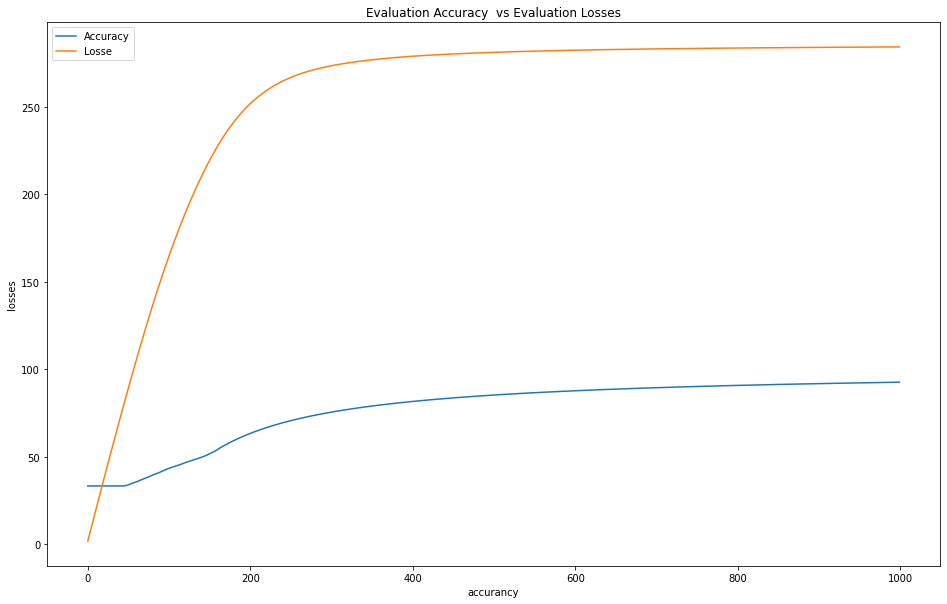

In [131]:
plt.figure(figsize=(16,10))
plt.plot(eval_accu)
plt.plot(eval_losses)
plt.xlabel('accurancy')
plt.ylabel('losses')
plt.legend(['Accuracy','Losse'])
plt.title('Evaluation Accuracy  vs Evaluation Losses')
 
plt.show()